# Model Selection

This script runs the model selection algorithm on on a provided dataset.

#### Key Indicators
For the selection of the model covariates we use a forward elimination procedure. Two key indicators are used for the model selection: the Akaike Information Criterion (AIC) and the Variance Inflation Factor (VIF). The AIC is an estimate of the in-sample prediction error that is commonly used to compare the quality of different statistical models for a given data. The aim of the indicator is to regularize the model by balancing the goodness-of-fit against model complexity and thereby avoiding both underfitting and overfitting. The AIC is calculated as follows:
$$
AIC = 2k - \ln(l),
$$
\noindent where $k$ is the number of model parameters, and $l$ denotes the maximum value of the model likelihood.

The VIF measures the degree of collinearity between independent variables, \ie if they have a close to linear relationship and are thus not independent from each other. Collinearity may cause problems in regression-like techniques as it inflates the variance of regression parameters and thus may lead to wrong identification of the relevant predictors. The 
$$
VIF = 1 / (1-R^2_i),
$$
\noindent where $R^2_i$ is the coefficient of determination of the regression of the $i$-th variable with all other explanatory variables.

#### Model Selection Algorithm
Our implementation of the model selection algorithm closely follows \cite{Barmpadimos11}. The algorithm executes as follows: (1) For each explanatory variable we fit a GAM model comprising just this single variable. The model with the lowest AIC is selected. (2) We iteratively search for the next best variable to be added to the existing model. Variables with $VIF >2.5$ are filtered out. Among the constructed candidate models, the one with the lowest AIC is chosen. The threshold of $2.5$ corresponds to the coefficient of determination $R^2=0.6$.


## Load Libraries & Data

The input needed for this script is a dataframe containing all potential explanatory variables for each day of observation - such a dataframe can be created from any dataframe with weather data using the "Generate Variables" Script. In addition to the explanatory variables it should also contain data about the independent variable (i.e. the pollutant) that should be analysed. If the dataset contains multiple pollutant variables, the variable of interest can be chosen by specifying 'in_var' accordingly.

In [1]:
# import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LinearGAM, LogisticGAM, s, f,l, GAM, te
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import math
import sklearn.mixture as mix
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import re
from scipy import stats
from dateutil.relativedelta import relativedelta
from dictionaries import starts, ends, che_classes, beijing_classes, wuhan_classes, at_classes, loc_classes

In [3]:
# get data 
data_path = 'che/df2.csv'
df = pd.read_csv(data_path, index_col = 0)

In [4]:
# convert index to datetime format
df.index = pd.to_datetime(df.index)

In [5]:
# get vector with names of all the cities
cities = np.unique(df['city'].values)
print('Cities contained in the dataset:',cities)

Cities contained in the dataset: ['Opfikon_Balsberg' 'StGallen_Blumenbergplatz' 'StGallen_Stuelegg'
 'Zuerich_Schimmelstrasse' 'Zuerich_Stampfenbachstrasse']


In [6]:
# get names of all avaialable varaiables
print('Variables available in the dataset:', df.columns.values)

Variables available in the dataset: ['pm10' 'co' 'press' 'h' 't' 'o3' 'p' 'nox' 'no2' 'no' 'ws' 'wd' 'city'
 'day_year' 'dew' 'pca' 'lagpca_year' 'lagpca_halfyear' 'lagpca_12weeks'
 'lagpca_8weeks' 'lagpca_4weeks' 'lagpca_2weeks' 'lagpca_1week'
 'lagws_4weeks' 'lagws_2weeks' 'lagws_1week' 'lagws_4weeks_max'
 'lagws_2weeks_max' 'lagws_1week_max' 'year' 'weekday' 'month' 'wx' 'wy'
 'h_lag1' 't_lag1' 'wx_lag1' 'wy_lag1' 'ws_lag1' 'dew_lag1' 'h_lag2'
 't_lag2' 'wx_lag2' 'wy_lag2' 'ws_lag2' 'dew_lag2' 'h_lag3' 't_lag3'
 'wx_lag3' 'wy_lag3' 'ws_lag3' 'dew_lag3']


In [7]:
# choose variable of interest & country
in_var ='no2'
loc = 'che'

## Plot Pollutant Distributions per Station

Air pollutants are assumed to generally follow a lognormal distribution. The following code prodcues a histogram of the pollutant concentration for any station with a fitted lognormal density curve. It can be used to explore the dataframe and get a first indication whether this assumption holds true for all stations and helps detect abnormalities.

/Users/abhiram/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


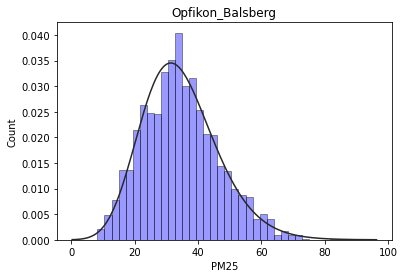

In [8]:
@interact
def dist_lpot(city = cities):
    df_city = df[df['city']==city]
    sns.distplot(df_city[in_var], hist=True, kde=False, 
                 bins=int(180/5), color = 'blue', fit=stats.lognorm,
                 hist_kws={'edgecolor':'black'})
    # Add labels
    plt.title(city)
    plt.xlabel('PM25')
    plt.ylabel('Count')
    plt.show()

## Model Selection Algorithm

The following function performs the model selection for a given city (i.e. station).

In [9]:
def GAMf_select(df, in_var, ex_vars, city, cut):
    """
    Parameters
    ----------
    df: 
        dataframe containing all variables of interest for the whole time of measurement
    in_var: 
        independent variable
    ex_vars: 
        list of explanatory variables
    city: 
        name of specific city
    cut: 
        string of the format '%m/%d/%Y' indicating the date when social distancing measures have been put into place
    train_duration:
        int, indicating the number of months that should be used for training
        defaults to 'all' -> all available data before the cut date will be used as training data
        
    Returns
    -------
    aic: 
        Akaike Information Criterion for the fitted Model
    max_vif:
        Highest Variance Inflation Factor for the fitted Model
    """

    # subset dataset to given city
    df = df[df['city']== city]
    
    # take only data until the date when social distancing measures have been put into place
    cut = datetime.strptime(cut, '%m/%d/%Y')    
    df_train = df[df.index<cut]
    
    # drop observations where not for all explanatory variables, measurements are available
    df_train = df_train.dropna(subset=ex_vars)

    # extract values for independent and explanatory variables
    train_X = df_train[ex_vars].values
    train_y = df_train[in_var].values
    
    # check if training set is not empty
    # otherwise construct formula for the GAM model
    if (len(train_X) != 0):
        string = str()
        if isinstance(ex_vars,str):
            length = 1
        else:
            length = len(ex_vars)
        for i in  range(0,length):
            if (ex_vars[i] in ['weekday', 'month','season','hour','new_year', 'daytime']):
                string = string + '+f(' + str(i) + ')'
          #  else:  
            if ('ws'in ex_vars[i]):
                string = string + '+l('+ str(i) +')'
            else:
                string = string + '+s(' + str(i) + ", lam = 0.6, basis = 'ps')"

        string = string[1:]

        # specify and get GAM model
        gam = GAM(eval(string),
                  distribution='normal', link='log')
        # fit GAM Model
        gam.fit(train_X, train_y) 
        
        # calculate VIF
        # set VIG to zero if we just have one explanatory variable
        if len(ex_vars)==1:
                max_vif =0
        else:
            vif = pd.DataFrame()
            vif["VIF"] = [variance_inflation_factor(train_X, i) for i in range(train_X.shape[1])]
    
            # get max observed VIF value
            max_vif = max(vif['VIF'])

        if max_vif is None:
            print('Warning VIF', ex_vars)
        elif gam.statistics_['AIC'] is None:
            print('Warnig AIC', ex_vars)
        else:
            # return the AIC and the maximum VIF value
            aic =gam.statistics_['AIC']
            return(aic, max_vif)
    else:
        return(0, float('Inf'))

## Perform Model Selection

In this part the dataframe is cleaned once more (i.e. we drop all observations were the independent variable is missing or has a negative value, which is impossible).

The variable 'cut' has to be specified to define the dataset which is used to perform the model selection, i.e. this should be the date where COVID-19 lockdown measures were put into place in the country of interest.

In [10]:
# date of lockdown measures put in place
cut = starts[loc]

In [11]:
# drop all columns with NaN values or negative values for the observed variable
df = df.replace(np.inf, np.nan)
df = df.dropna(subset=[in_var])
df = df.drop(df[df[in_var]<0].index)

In [12]:
ex_vars_all = ['t', 'h', 'ws', 'dew',
 'pca', 'lagpca_year', 'lagpca_halfyear', 'lagpca_12weeks', 'lagpca_8weeks',
 'lagpca_4weeks', 'lagpca_2weeks', 'lagpca_1week', 'lagws_4weeks',
 'lagws_2weeks', 'lagws_1week', 'lagws_4weeks_max', 'lagws_2weeks_max',
 'lagws_1week_max', 'year', 'weekday', 'month', 'wx', 'wy',  'h_lag1',
 't_lag1', 'wx_lag1', 'wy_lag1', 'ws_lag1', 'dew_lag1', 'h_lag2', 't_lag2',
 'wx_lag2', 'wy_lag2', 'ws_lag2', 'dew_lag2', 'h_lag3', 't_lag3', 'wx_lag3',
 'wy_lag3', 'ws_lag3', 'dew_lag3']

In [13]:
# generate column names for output datafram
col_names = []
model_names = []
aic_names =[]
j=1
for i in ex_vars_all:
    aic_names.append('var_'+ str(j))
    aic_names.append('aic_'+ str(j))
    aic_names.append('vif_'+ str(j))
    j = j+1

In [14]:
# implementation of the model selection algorithm

# initalise dataframes to collect output
all_stats = pd.DataFrame(data = None, index = cities, columns = aic_names)
chosen_vars = pd.DataFrame(data =None, index = cities)
# make calculations for every city
for city in cities:
    
    # initalise list & series to track outcomes
    used_vars = list()
    aics = pd.Series(data = None, index = ex_vars_all, dtype = 'float64')
    vifs = pd.Series(data = None, index = ex_vars_all, dtype = 'float64')
    
    used_vars2 = list()
    aics2 = pd.Series(data = None, index = ex_vars_all, dtype = 'float64')
    vifs2 = pd.Series(data = None, index = ex_vars_all, dtype = 'float64')

    # for every variable in the list of explanatory variables
    for j in range(0, len(ex_vars_all)):
        
        # get a list of all variables that are not yet included in the model
        ex_vars = [x for x in ex_vars_all if x not in used_vars]
        
        # for every variable not yet included in the model
        for i, ex_var in enumerate(ex_vars):
            gam_vars = used_vars.copy()
            gam_vars.append(ex_var)
            # fit a GAM model with the new variable added to the previous model & calculate AIC and VIF
            if GAMf_select(df, in_var, gam_vars, city, cut) is None:
                print('Error', city, gam_vars)
            else:
                aics[ex_var], vifs[ex_var] =  GAMf_select(df, in_var, gam_vars, city, cut)
        #print(aics)
        # filter all models with a maaximum VIF Score < 2.5
        low = vifs[vifs<2.5].index

        # if not for all models the included variables have a VIF Score > 2.5, select the model with the lowwest AIC
        if (len(aics[low]) != 0):
            chosen_var = aics[low].idxmin()
        else:
            break
        # if the the AIC score is not lower than the one of the previous model -> stop 
        if chosen_var in used_vars:
            break
                        
        # add selected variable and statistics to the all_stats Dataframe
        all_stats.loc[city,aic_names[(j+1)*3-3]] = chosen_var
        all_stats.loc[city, aic_names[(j+1)*3-2]] = aics[low].min()
        all_stats.loc[city, aic_names[(j+1)*3-1]] = vifs[chosen_var]
        
        # add selected variable to the chosen_var Dataframe
        used_vars.append(chosen_var)
        chosen_vars.loc[city,j] = chosen_var
        
        print(city, 'Round #', str(j+1), ': ', chosen_var)

Opfikon_Balsberg Round # 1 :  lagpca_halfyear
Opfikon_Balsberg Round # 2 :  wy
Opfikon_Balsberg Round # 3 :  weekday
Opfikon_Balsberg Round # 4 :  pca
Opfikon_Balsberg Round # 5 :  ws_lag3
Opfikon_Balsberg Round # 6 :  wx
Opfikon_Balsberg Round # 7 :  h
StGallen_Blumenbergplatz Round # 1 :  t_lag3
StGallen_Blumenbergplatz Round # 2 :  ws
StGallen_Blumenbergplatz Round # 3 :  wx_lag1
StGallen_Blumenbergplatz Round # 4 :  h_lag1
StGallen_Blumenbergplatz Round # 5 :  wy_lag2
StGallen_Blumenbergplatz Round # 6 :  wx
StGallen_Blumenbergplatz Round # 7 :  h_lag3
StGallen_Stuelegg Round # 1 :  t
StGallen_Stuelegg Round # 2 :  ws
StGallen_Stuelegg Round # 3 :  pca
StGallen_Stuelegg Round # 4 :  wx_lag3
StGallen_Stuelegg Round # 5 :  h_lag2
StGallen_Stuelegg Round # 6 :  wy_lag3
StGallen_Stuelegg Round # 7 :  h_lag3
StGallen_Stuelegg Round # 8 :  h_lag1
StGallen_Stuelegg Round # 9 :  h
Zuerich_Schimmelstrasse Round # 1 :  ws_lag3
Zuerich_Schimmelstrasse Round # 2 :  month
Zuerich_Schimmelstrass

In [15]:
# print table with the variables for each station chosen by the selection algorithm
chosen_vars

,0,1,2,3,4,5,6,7,8
Opfikon_Balsberg,lagpca_halfyear,wy,weekday,pca,ws_lag3,wx,h,NaN,NaN
StGallen_Blumenbergplatz,t_lag3,ws,wx_lag1,h_lag1,wy_lag2,wx,h_lag3,NaN,NaN
StGallen_Stuelegg,t,ws,pca,wx_lag3,h_lag2,wy_lag3,h_lag3,h_lag1,h
Zuerich_Schimmelstrasse,ws_lag3,month,lagpca_1week,lagpca_halfyear,NaN,NaN,NaN,NaN,NaN
Zuerich_Stampfenbachstrasse,lagws_1week,month,lagpca_1week,lagpca_12weeks,NaN,NaN,NaN,NaN,NaN


In [16]:
# print table with the total count of how often each variable was chosen
chosen_vars.apply(pd.value_counts).sum(axis=1)

h                  2.0
h_lag1             2.0
h_lag2             1.0
h_lag3             2.0
lagpca_12weeks     1.0
lagpca_1week       2.0
lagpca_halfyear    2.0
lagws_1week        1.0
month              2.0
pca                2.0
t                  1.0
t_lag3             1.0
weekday            1.0
ws                 2.0
ws_lag3            2.0
wx                 2.0
wx_lag1            1.0
wx_lag3            1.0
wy                 1.0
wy_lag2            1.0
wy_lag3            1.0
dtype: float64

In [17]:
# save output to csv
chosen_vars.to_csv('./' + loc + '/' + in_var + '_chosen_vars.csv')
all_stats.to_csv('./' + loc + '/' + in_var +'_all_stats.csv')